## Author: Ran Meng

This jupyter notebook contains my work for certification of "Market Basket Analysis in Python" instructed by Isaiah Hull, from [DataCamp](https://app.datacamp.com/learn/courses/market-basket-analysis-in-python)

In [5]:
import pandas as pd, numpy as np
#import seaborn as sns
from itertools import permutations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates

## Introduction to Market Basket Analysis

#### Cross-selling products

The small grocery store has decided to cross-sell chewing gum with either coffee, cereal, or bread. To determine which of the three items is best to use, the store owner has performed an experiment. For one week, she sold chewing gum next to the register and recorded all transactions where it was purchased with either coffee, cereal, or bread. The transactions from that day are available as a list of lists named transactions. Each transaction is either ['coffee','gum'], ['cereal','gum'], or ['bread','gum'].

In [3]:
transactions = [['bread', 'gum'],
 ['bread', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['cereal', 'gum'],
 ['bread', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['bread', 'gum'],
 ['cereal', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['cereal', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['cereal', 'gum'],
 ['bread', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['cereal', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['cereal', 'gum'],
 ['cereal', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['bread', 'gum'],
 ['coffee', 'gum'],
 ['coffee', 'gum']]

In [4]:
# Count the number of transactions with coffee and gum
coffee = transactions.count(['coffee', 'gum'])

# Count the number of transactions with cereal and gum
cereal = transactions.count(['cereal', 'gum'])

# Count the number of transactions with bread and gum
bread = transactions.count(['bread', 'gum'])

# Print the counts for each transaction.
print('coffee:', coffee)
print('cereal:', cereal)
print('bread:', bread)

coffee: 40
cereal: 25
bread: 20


#### Preparing data for market basket analysis

Throughout this course, you will typically encounter data in one of two formats: a pandas DataFrame or a list of lists. DataFrame objects will be constructed by importing a csv file using pandas. They will consist of a single column of data, where each element contains a string of items in a transaction, separated by a comma, as in the table below.

In this exercise, you will practice loading the data from a csv file and will prepare it for use as a list of lists. Note that the path to the grocery store dataset has been defined and is available to you as groceries_path.

In [5]:
groceries_path = 'https://assets.datacamp.com/production/repositories/5654/datasets/5992818fd324b0de7d48311ee43fa038f7614ee5/small_grocery_store.csv'

In [6]:
groceries = pd.read_csv(groceries_path)

In [7]:
groceries.head()

,Transaction
0,"milk,bread,biscuit"
1,"bread,milk,biscuit,cereal"
2,"bread,tea"
3,"jam,bread,milk"
4,"tea,biscuit"


In [8]:
groceries.shape

(20, 1)

In [9]:
# Split transaction strings into lists
transactions = groceries['Transaction'].apply(lambda t: t.split(','))

transactions.head()

0            [milk, bread, biscuit]
1    [bread, milk, biscuit, cereal]
2                      [bread, tea]
3                [jam, bread, milk]
4                    [tea, biscuit]
Name: Transaction, dtype: object

In [10]:
# Convert DataFrame column into list of strings
transactions = list(transactions)

# Print the list of transactions
print(transactions)

[['milk', 'bread', 'biscuit'], ['bread', 'milk', 'biscuit', 'cereal'], ['bread', 'tea'], ['jam', 'bread', 'milk'], ['tea', 'biscuit'], ['bread', 'tea'], ['tea', 'cereal'], ['bread', 'tea', 'biscuit'], ['jam', 'bread', 'tea'], ['bread', 'milk'], ['coffee', 'orange', 'biscuit', 'cereal'], ['coffee', 'orange', 'biscuit', 'cereal'], ['coffee', 'sugar'], ['bread', 'coffee', 'orange'], ['bread', 'sugar', 'biscuit'], ['coffee', 'sugar', 'cereal'], ['bread', 'sugar', 'biscuit'], ['bread', 'coffee', 'sugar'], ['bread', 'coffee', 'sugar'], ['tea', 'milk', 'coffee', 'cereal']]


#### Generating association rules

As you saw, the function permutations from the module itertools can be used to quickly generate the set of all one-antecedent, one-consequent rules. You do not, of course, know which of these rules are useful. You simply know that each is a valid way to combine two items.

Let's practice generating and counting the set of all rules for a subset of the grocery dataset: coffee, tea, milk, and sugar.

In [11]:
# Define the set of groceries
flattened = [i for t in transactions for i in t]
groceries = list(set(flattened))

print(groceries)

['milk', 'sugar', 'tea', 'cereal', 'bread', 'coffee', 'biscuit', 'jam', 'orange']


In [12]:
# Generate all possible rules from groceries list
rules = list(permutations(groceries, 2))

# Print the set of rules
print(rules)

# Print the number of rules
print(len(rules))

[('milk', 'sugar'), ('milk', 'tea'), ('milk', 'cereal'), ('milk', 'bread'), ('milk', 'coffee'), ('milk', 'biscuit'), ('milk', 'jam'), ('milk', 'orange'), ('sugar', 'milk'), ('sugar', 'tea'), ('sugar', 'cereal'), ('sugar', 'bread'), ('sugar', 'coffee'), ('sugar', 'biscuit'), ('sugar', 'jam'), ('sugar', 'orange'), ('tea', 'milk'), ('tea', 'sugar'), ('tea', 'cereal'), ('tea', 'bread'), ('tea', 'coffee'), ('tea', 'biscuit'), ('tea', 'jam'), ('tea', 'orange'), ('cereal', 'milk'), ('cereal', 'sugar'), ('cereal', 'tea'), ('cereal', 'bread'), ('cereal', 'coffee'), ('cereal', 'biscuit'), ('cereal', 'jam'), ('cereal', 'orange'), ('bread', 'milk'), ('bread', 'sugar'), ('bread', 'tea'), ('bread', 'cereal'), ('bread', 'coffee'), ('bread', 'biscuit'), ('bread', 'jam'), ('bread', 'orange'), ('coffee', 'milk'), ('coffee', 'sugar'), ('coffee', 'tea'), ('coffee', 'cereal'), ('coffee', 'bread'), ('coffee', 'biscuit'), ('coffee', 'jam'), ('coffee', 'orange'), ('biscuit', 'milk'), ('biscuit', 'sugar'), ('b

#### One-hot encoding transaction data

Throughout the course, we will use a common pipeline for preprocessing data for use in market basket analysis. The first step is to import a pandas DataFrame and select the column that contains transactions. Each transaction in the column will be a string that consists of a number of items, each separated by a comma. The next step is to use a lambda function to split each transaction string into a list, thereby transforming the column into a list of lists.

In this exercise, you'll start with the list of lists from the grocery dataset, which is available to you as transactions. You will then transform transactions into a one-hot encoded DataFrame, where each column consists of TRUE and FALSE values that indicate whether an item was included in a transaction.

In [13]:
# Instantiate transaction encoder and identify unique items in transactions
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

# Print the one-hot encoded transaction dataset
print(onehot)

    biscuit  bread  cereal  coffee    jam   milk  orange  sugar    tea
0      True   True   False   False  False   True   False  False  False
1      True   True    True   False  False   True   False  False  False
2     False   True   False   False  False  False   False  False   True
3     False   True   False   False   True   True   False  False  False
4      True  False   False   False  False  False   False  False   True
5     False   True   False   False  False  False   False  False   True
6     False  False    True   False  False  False   False  False   True
7      True   True   False   False  False  False   False  False   True
8     False   True   False   False   True  False   False  False   True
9     False   True   False   False  False   True   False  False  False
10     True  False    True    True  False  False    True  False  False
11     True  False    True    True  False  False    True  False  False
12    False  False   False    True  False  False   False   True  False
13    

#### Computing the support metric

In the previous exercise, you one-hot encoded a small grocery store's transactions as the DataFrame onehot. In this exercise, you'll make use of that DataFrame and the support metric to help the store's owner. First, she has asked you to identify frequently purchased items, which you'll do by computing support at the item-level. And second, she asked you to check whether the rule {jam} 
 {bread} has a support of over 0.05. 

In [15]:
# Compute the support
support = onehot.mean()

# Print the support
print(support)

biscuit    0.40
bread      0.65
cereal     0.30
coffee     0.40
jam        0.10
milk       0.25
orange     0.15
sugar      0.30
tea        0.35
dtype: float64


In [16]:
# Add a jam+bread column to the DataFrame onehot
onehot['jam+bread'] = np.logical_and(onehot['jam'], onehot['bread'])

# Compute the support
support = onehot.mean()

# Print the support values
print(support)

biscuit      0.40
bread        0.65
cereal       0.30
coffee       0.40
jam          0.10
milk         0.25
orange       0.15
sugar        0.30
tea          0.35
jam+bread    0.10
dtype: float64


## Association Rules

#### Recommending books with support

A library wants to get members to read more and has decided to use market basket analysis to figure out how. They approach you to do the analysis and ask that you use the five most highly-rated books from the goodbooks-10k dataset, which was introduced in the video. You are given the data in one-hot encoded format in a pandas DataFrame called books.

Each column in the DataFrame corresponds to a book and has the value TRUE if the book is contained in a reader's library and is rated highly. To make things simpler, we'll work with shortened book names: Hunger, Potter, and Twilight.

In [ ]:
# Compute support for Hunger and Potter
supportHP = np.logical_and(books['Hunger'], books['Potter']).mean()

# Compute support for Hunger and Twilight
supportHT = np.logical_and(books['Hunger'], books['Twilight']).mean()

# Compute support for Potter and Twilight
supportPT = np.logical_and(books['Potter'], books['Twilight']).mean()

# Print support values
print("Hunger Games and Harry Potter: %.2f" % supportHP) # 0.12
print("Hunger Games and Twilight: %.2f" % supportHT) # 0.09
print("Harry Potter and Twilight: %.2f" % supportPT) # 0.14

In [18]:
'''Based on the support metric, Harry Potter and Twilight appear to be the best options for cross-promotion. In the next problem, we'll consider whether we should use Harry Potter to promote Twilight or Twilight to promote Harry Potter.'''

"Based on the support metric, Harry Potter and Twilight appear to be the best options for cross-promotion. In the next problem, we'll consider whether we should use Harry Potter to promote Twilight or Twilight to promote Harry Potter."

#### Refining support with confidence

After reporting your findings from the previous exercise, the library asks you about the direction of the relationship. Should they use Harry Potter to promote Twilight or Twilight to promote Harry Potter?

After thinking about this, you decide to compute the confidence metric, which has a direction, unlike support. You'll compute it for both {Potter} -> {Twilight} and {Twilight} -> {Potter}. The DataFrame books has been imported for you, which has one column for each book: Potter and Twilight.

In [ ]:
# Compute support for Potter and Twilight
supportPT = np.logical_and(books['Potter'], books['Twilight']).mean()

# Compute support for Potter
supportP = books['Potter'].mean()

# Compute support for Twilight
supportT = books['Twilight'].mean()

# Compute confidence for both rules
confidencePT = supportPT / supportP
confidenceTP = supportPT/ supportT

# Print results
print('{0:.2f}, {1:.2f}'.format(confidencePT, confidenceTP)) # 0.29, 0.55

In [19]:
'''Even though the support is identical for the two association rules, the confidence is much higher for Twilight -> Harry Potter, since Harry Potter has a higher support than Twilight.'''

'Even though the support is identical for the two association rules, the confidence is much higher for Twilight -> Harry Potter, since Harry Potter has a higher support than Twilight.'

#### Further refinement with lift

Once again, you report your results to the library: Use Twilight to promote Harry Potter, since the rule has a higher confidence metric. The library thanks you for the suggestion, but asks you to confirm that this is a meaningful relationship using another metric.

You recall that lift may be useful here. If lift is less than 1, this means that Harry Potter and Twilight are paired together less frequently than we would expect if the pairings occurred by random chance.

In [ ]:
# Compute support for Potter and Twilight
supportPT = np.logical_and(books['Potter'], books['Twilight']).mean()

# Compute support for Potter
supportP = books['Potter'].mean()

# Compute support for Twilight
supportT = books['Twilight'].mean()

# Compute lift
lift = supportPT / (supportP * supportT)

# Print lift
print("Lift: %.2f" % lift) # 1.15

In [21]:
'''As it turns out, lift is greater than 1.0. This could give us some confidence that the association rule we recommended did not arise by random chance.'''

'As it turns out, lift is greater than 1.0. This could give us some confidence that the association rule we recommended did not arise by random chance.'

#### Computing conviction

After hearing about the useful advice you provided to the library, the founder of a small ebook selling start-up approaches you for consulting services. As a test of your abilities, she asks you if you are able to compute conviction for the rule {Potter} 
 {Hunger}, so she can decide whether to place the books next to each other on the company's website. Fortunately, you still have access to the goodreads-10k data, which is available as books.

In [ ]:
# Compute support for Potter AND Hunger
supportPH = np.logical_and(books['Potter'], books['Hunger']).mean()

# Compute support for Potter
supportP = books['Potter'].mean()

# Compute support for NOT Hunger
supportnH = 1.0 - books['Hunger'].mean()

# Compute support for Potter and NOT Hunger
supportPnH = supportP - supportPH

# Compute and print conviction for Potter -> Hunger
conviction = supportP * supportnH / supportPnH
print("Conviction: %.2f" % conviction) # 0.92

In [22]:
'''Notice that the value of conviction was less than 1, suggesting that the rule ``if Potter then Hunger'' is not supported'''

"Notice that the value of conviction was less than 1, suggesting that the rule ``if Potter then Hunger'' is not supported"

#### Computing conviction with a function

After successful completion of her trial project, the ebook start-up's founder decides to hire you for a much bigger project. She asks you if you are able to compute conviction for every pair of books in the goodreads-10k dataset, so she can use that information to decide which books to locate closer together on the website.

You agree to take the job, but realize that you need more a efficient way to compute conviction, since you will need to compute it many times. You decide to write a function that computes it. It will take two columns of a pandas DataFrame as an input, one antecedent and one consequent, and output the conviction metric.

In [23]:
def conviction(antecedent, consequent):
	# Compute support for antecedent AND consequent
	supportAC = np.logical_and(antecedent, consequent).mean()

	# Compute support for antecedent
	supportA = antecedent.mean()

	# Compute support for NOT consequent
	supportnC = 1.0 - consequent.mean()

	# Compute support for antecedent and NOT consequent
	supportAnC = supportA - supportAC

    # Return conviction
	return supportA * supportnC / supportAnC

#### Promoting ebooks with conviction

In the previous exercise, we defined a function to compute conviction. We were asked to apply that function to all two-book permutations of the goodreads-10k dataset. In this exercise, we'll test the function by applying it to the three most popular books, which we used in earlier exercises: The Hunger Games, Harry Potter, and Twilight.

The function has been defined for you and is available as conviction. Recall that it takes an antecedent and a consequent as its two arguments. Additionally, the columns of the books DataFrame from earlier exercises are available as three separate DataFrames: potter, twilight, and hunger.

In [ ]:
# Compute conviction for twilight -> potter and potter -> twilight
convictionTP = conviction(twilight, potter)
convictionPT = conviction(potter, twilight)

# Compute conviction for twilight -> hunger and hunger -> twilight
convictionTH = conviction(twilight, hunger)
convictionHT = conviction(hunger, twilight)

# Compute conviction for potter -> hunger and hunger -> potter
convictionPH = conviction(potter, hunger)
convictionHP = conviction(hunger, potter)

# Print results
print('Harry Potter -> Twilight: ', convictionHT) # 1.0315274939515657
print('Twilight -> Potter: ', convictionTP) # 1.1550539077290998

In [25]:
'''Notice that the conviction metric for if Potter then Twilight and if Twilight then Potter are both above 1, indicating that they are both viable rules.'''

'Notice that the conviction metric for if Potter then Twilight and if Twilight then Potter are both above 1, indicating that they are both viable rules.'

#### Computing association and dissociation

The library has returned to you once again about your recommendation to promote Harry Potter using Twilight. They're worried that the two might be dissociated, which could have a negative impact on their promotional effort. They ask you to verify that this is not the case.

You immediately think of Zhang's metric, which measures association and dissociation continuously. Association is positive and dissociation is negative. As with the previous exercises, the DataFrame books has been imported for you, along with numpy under the alias np. Zhang's metric is computed as follows:

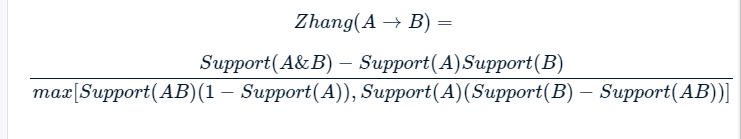

In [ ]:
# Compute the support of Twilight and Harry Potter
supportT = books['Twilight'].mean()
supportP = books['Potter'].mean()

# Compute the support of both books
supportTP = np.logical_and(books['Twilight'], books['Potter']).mean()

# Complete the expressions for the numerator and denominator
numerator = supportTP - supportT*supportP
denominator = max(supportTP*(1-supportT), supportT*(supportP-supportTP))

# Compute and print Zhang's metric
zhang = numerator / denominator
print(zhang) # 0.17231567178855997

In [26]:
'''Once again, the association rule ``if Twilight then Harry Potter'' proved robust. It had a positive value for Zhang's metric, indicating that the two books are not dissociated.'''

"Once again, the association rule ``if Twilight then Harry Potter'' proved robust. It had a positive value for Zhang's metric, indicating that the two books are not dissociated."

In [27]:
# Define a function to compute Zhang's metric
def zhang(antecedent, consequent):
	# Compute the support of each book
	supportA = antecedent.mean()
	supportC = consequent.mean()

	# Compute the support of both books
	supportAC = np.logical_and(antecedent, consequent).mean()

	# Complete the expressions for the numerator and denominator
	numerator = supportAC - supportA*supportC
	denominator = max(supportAC*(1-supportA), supportA*(supportC-supportAC))

	# Return Zhang's metric
	return numerator / denominator

#### Applying Zhang's metric

The founder of the ebook start-up has returned for additional consulting services. She has sent you a list of itemsets she's investigating and has asked you to determine whether any of them contain items that are dissociated. When you're finished, she has asked that you add the metric you use to a column in the rules DataFrame, which is available to you, and currently contains columns for antecedents and consequents.

The itemsets are available as a list of lists called itemsets. Each list contains the antecedent first and the consequent second. You also have access to the books DataFrame from previous exercises. Note that Zhang's metric has been defined for you and is available as zhang(). 

In [32]:
d = {'antecedents': ['Potter', 'Twilight', 'Mockingbird', 'Gatsby', 'Potter','Potter','Potter', 'Mockingbird', 'Gatsby', 'Mockingbird'], \
     'consequents': ['Hunger', 'Hunger','Hunger','Hunger', 'Twilight', 'Mockingbird', 'Gatsby', 'Twilight','Twilight', 'Gatsby']}
rules = pd.DataFrame(d)

rules

,antecedents,consequents
0,Potter,Hunger
1,Twilight,Hunger
2,Mockingbird,Hunger
3,Gatsby,Hunger
4,Potter,Twilight
5,Potter,Mockingbird
6,Potter,Gatsby
7,Mockingbird,Twilight
8,Gatsby,Twilight
9,Mockingbird,Gatsby


In [31]:
itemsets = [['Potter', 'Hunger'],
 ['Twilight', 'Hunger'],
 ['Mockingbird', 'Hunger'],
 ['Gatsby', 'Hunger'],
 ['Potter', 'Twilight'],
 ['Potter', 'Mockingbird'],
 ['Potter', 'Gatsby'],
 ['Mockingbird', 'Twilight'],
 ['Gatsby', 'Twilight'],
 ['Mockingbird', 'Gatsby']]

In [ ]:
# Define an empty list for Zhang's metric
zhangs_metric = []

# Loop over lists in itemsets
for itemset in itemsets:
    # Extract the antecedent and consequent columns
	antecedent = books[itemset[0]]
	consequent = books[itemset[1]]
    
    # Complete Zhang's metric and append it to the list
	zhangs_metric.append(zhang(antecedent, consequent))
    
# Print results
rules['zhang'] = zhangs_metric
print(rules)

         antecedents  consequents  zhang
    0       Potter       Hunger -0.306
    1     Twilight       Hunger  0.109
    2  Mockingbird       Hunger -0.525
    3       Gatsby       Hunger -0.550
    4       Potter     Twilight  0.245
    5       Potter  Mockingbird -0.066
    6       Potter       Gatsby -0.166
    7  Mockingbird     Twilight -0.319
    8       Gatsby     Twilight -0.371
    9  Mockingbird       Gatsby  0.466

In [33]:
'''Notice that most of the items were dissociated, which suggests that they would have been a poor choice to pair together for promotional purposes.'''

'Notice that most of the items were dissociated, which suggests that they would have been a poor choice to pair together for promotional purposes.'

#### Filtering with support and conviction

In the video, we discussed the continued consulting work you are doing for the founder of an ebook selling start-up. The founder has approached you with the DataFrame rules, which contains the work of a data scientist who was previously on staff. It includes columns for antecedents and consequents, along with the performance for each of those rules with respect to a number of metrics.

Your objective will be to perform multi-metric filtering on the dataset to identify potentially useful rules.

In [ ]:
# Preview the rules DataFrame using the .head() method
print(rules.head())

    antecedents consequents  antecedent support  consequent support  support  confidence   lift  leverage  conviction
0       (Hunger)    (Potter)               0.319               0.478    0.124       0.388  0.813    -0.029       0.854
1       (Potter)    (Hunger)               0.478               0.319    0.124       0.259  0.813    -0.029       0.919
2     (Twilight)    (Hunger)               0.257               0.319    0.089       0.347  1.088     0.007       1.043
3       (Hunger)  (Twilight)               0.319               0.257    0.089       0.279  1.088     0.007       1.032
4  (Mockingbird)    (Hunger)               0.477               0.319    0.096       0.202  0.633    -0.056       0.853

In [ ]:
# Select the subset of rules with antecedent support greater than 0.05
rules = rules[rules['antecedent support'] > 0.05]

# Select the subset of rules with a consequent support greater than 0.02
rules = rules[rules['consequent support'] > 0.02]

# Select the subset of rules with a conviction greater than 1.01
rules = rules[rules['conviction'] > 1.01]

# Print remaining rules
print(rules) # 82 x 9

#### Using multi-metric filtering to cross-promote books

As a final request, the founder of the ebook selling start-up asks you to perform additional filtering. Your previous attempt returned 82 rules, but she wanted only one. The rules dataset has again been made available in the console. Finally, Zhang's metric has been computed for you and included in the rules DataFrame under the column header zhang.

In [ ]:
# Set the lift threshold to 1.5
rules = rules[rules['lift'] > 1.5]

# Set the conviction threshold to 1.0
rules = rules[rules['conviction'] > 1.0]

# Set the threshold for Zhang's rule to 0.65
rules = rules[rules['zhang'] > 0.65]

# Print rule
print(rules[['antecedents','consequents']])

                  antecedents               consequents
    114    (Mockingbird, Potter)          (Gatsby, Hunger)
    118            (Mockingbird)  (Gatsby, Hunger, Potter)
    126  (Twilight, Mockingbird)          (Gatsby, Hunger)
    130    (Mockingbird, Hunger)        (Twilight, Gatsby)
    144    (Mockingbird, Potter)        (Twilight, Gatsby)

## Aggregation and Pruning

#### Performing aggregation

After completing minor consulting jobs for a library and an ebook seller, you've finally received your first big market basket analysis project: advising an online novelty gifts retailer on cross-promotions. Since the retailer has never previously hired a data scientist, it would like you to start the project by exploring its transaction data. It has asked you to perform aggregation for all signs in the dataset and also compute the support for this category. Note that pandas has been imported for you as pd. Additionally, the data has been imported in one-hot encoded format as onehot.

In [ ]:
# Select the column headers for sign items
sign_headers = [i for i in onehot.columns if i.lower().find('sign')>=0]

# Select columns of sign items using sign_headers
sign_columns = onehot[sign_headers]

# Perform aggregation of sign items into sign category
signs = sign_columns.sum(axis = 1) >= 1.0

# Print support for signs
print('Share of Signs: %.2f' % signs.mean()) #  0.10

In [2]:
'''Excellent work! If you look at the printed statement, you'll notice that support for signs is 0.10, which suggests that signs are an important category of items for the retailer.'''

"Excellent work! If you look at the printed statement, you'll notice that support for signs is 0.10, which suggests that signs are an important category of items for the retailer."

#### Defining an aggregation function

Surprised by the high share of sign items in its inventory, the retailer decides that it makes sense to do further aggregation for different categories to explore the data better. This seems trivial to you, but the retailer has not previously been able to perform even a basic descriptive analysis of its transaction and items.

The retailer asks you to perform aggregation for the candles, bags, and boxes categories. To simplify the task, you decide to write a function. It will take a string that contains an item's category. It will then output a DataFrame that indicates whether each transaction includes items from that category. Note that pandas has been imported for you as pd. Additionally, the data has been imported in one-hot encoded format as onehot.

In [ ]:
def aggregate(item):
	# Select the column headers for sign items in onehot
	item_headers = [i for i in onehot.columns if i.lower().find(item)>=0]

	# Select columns of sign items
	item_columns = onehot[item_headers]

	# Return category of aggregated items
	return item_columns.sum(axis = 1) >= 1.0

# Aggregate items for the bags, boxes, and candles categories  
bags = aggregate('bag')
boxes = aggregate('boxes')
candles = aggregate('candles')

#### Identifying frequent itemsets with Apriori

The aggregation exercise you performed for the online retailer proved helpful. It offered a starting point for understanding which categories of items appear frequently in transactions. The retailer now wants to explore the individual items themselves to find out which are frequent.

In this exercise, you'll apply the Apriori algorithm to the online retail dataset without aggregating first. Your objective will be to prune the itemsets using a minimum value of support and a maximum item number threshold. Note that pandas has been imported as pd and the one-hot encoded data is available as onehot.

In [ ]:
# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, 
                            min_support = 0.006, 
                            max_len = 3, 
                            use_colnames = True)

# Print a preview of the frequent itemsets
print(frequent_itemsets.head())

      support                              itemsets
    0    0.007          (HOT WATER BOTTLE KEEP CALM)
    1    0.008             (JUMBO BAG RED RETROSPOT)
    2    0.006     (PAPER CHAIN KIT 50'S CHRISTMAS )
    3    0.006                      (POPCORN HOLDER)
    4    0.007  (WHITE HANGING HEART T-LIGHT HOLDER)

In [ ]:
# Compute frequent itemsets using a support of 0.003 and length of 3
frequent_itemsets_1 = apriori(onehot, min_support = 0.003, 
                            max_len = 3, use_colnames = True)

# Compute frequent itemsets using a support of 0.001 and length of 3
frequent_itemsets_2 = apriori(onehot, min_support = 0.001, 
                            max_len = 3, use_colnames = True)

# Print the number of freqeuent itemsets
print(len(frequent_itemsets_1)) # 429
print(len(frequent_itemsets_2)) # 91

#### Generating association rules

In the final exercise of the previous section, you computed itemsets for the novelty gift store owner using the Apriori algorithm. You told the store owner that relaxing support from 0.005 to 0.003 increased the number of itemsets from 9 to 91. Relaxing it again to 0.001 increased the number to 429. Satisfied with the descriptive work you've done, the store manager asks you to identify some association rules from those two sets of frequent itemsets you computed.

In [ ]:
# Compute all association rules for frequent_itemsets_1
rules_1 = association_rules(frequent_itemsets_1, 
                            metric = "support", 
                         	min_threshold = 0.0015)

# Compute all association rules for frequent_itemsets_2
rules_2 = association_rules(frequent_itemsets_2, 
                            metric = "support", 
                        	min_threshold = 0.0015)

# Print the number of association rules generated
print(len(rules_1)) # 0
print(len(rules_2)) # 2

#### Pruning with lift

Once again, you report back to the novelty gift store manager. This time, you tell her that you identified no rules when you used a higher support threshold for the Apriori algorithm and only two rules when you used a lower threshold. She commends you for the good work, but asks you to consider using another metric to reduce the two rules to one.

You remember that lift had a simple interpretation: values greater than 1 indicate that items co-occur more than we would expect if they were independently distributed across transactions. You decide to use lift, since that message will be simple to convey.

In [ ]:
# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.001, 
                            max_len = 2, use_colnames = True)

# Compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets, 
                            metric = "lift", 
                         	min_threshold = 1.0)

# Print association rules
print(rules)

In [ ]:
                antecedents                  consequents  antecedent support  consequent support  support  confidence    lift  leverage  conviction
    0    (JUMBO BAG RED RETROSPOT)  (BIRTHDAY CARD, RETRO SPOT)               0.008               0.002    0.002       0.200  88.667     0.001       1.247
    1  (BIRTHDAY CARD, RETRO SPOT)    (JUMBO BAG RED RETROSPOT)               0.002               0.008    0.002       0.667  88.667     0.001       2.977

#### Pruning with confidence

Once again, you've come up short: you found multiple useful rules, but can't narrow it down to one. Even worse, the two rules you found used the same itemset, but just swapped the antecedents and consequents. You decide to see whether pruning by another metric might allow you to narrow things down to a single association rule.

What would be the right metric? Both lift and support are identical for all rules that can be generated from an itemset, so you decide to use confidence instead, which differs for rules produced from the same itemset.

In [ ]:
# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.0015, 
                            max_len = 2, use_colnames = True)

# Compute all association rules using confidence
rules = association_rules(frequent_itemsets, 
                            metric = "confidence", 
                         	min_threshold = 0.5)

# Print association rules
print(rules)

In [ ]:
             antecedents                consequents  antecedent support  consequent support  support  confidence    lift  leverage  conviction
    0  (BIRTHDAY CARD, RETRO SPOT)  (JUMBO BAG RED RETROSPOT)               0.002               0.008    0.002       0.667  88.667     0.001       2.977

##### Aggregation and filtering

In the video, we helped a gift store manager arrange the sections in her physical retail location according to association rules. The layout of the store forced us to group sections into two pairs of product types. After applying advanced filtering techniques, we proposed the floor layout below.

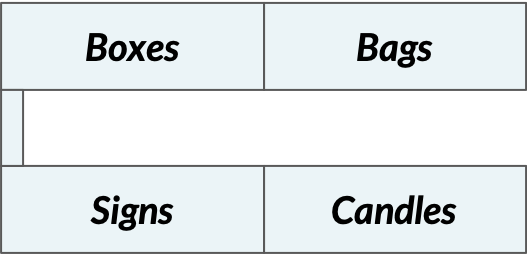

The store manager is now asking you to generate another floorplan proposal, but with a different criterion: each pair of sections should contain one high support product and one low support product. The data, aggregated, has been aggregated and one-hot encoded for you. 

In [ ]:
# Apply the apriori algorithm with a minimum support of 0.0001
frequent_itemsets = apriori(aggregated, min_support = 0.0001, use_colnames = True)

# Generate the initial set of rules using a minimum support of 0.0001
rules = association_rules(frequent_itemsets, 
                          metric = "support", min_threshold = 0.0001)

# Set minimum antecedent support to 0.35
rules = rules[rules['antecedent support'] > 0.35]

# Set maximum consequent support to 0.35
rules = rules[rules['consequent support'] < 0.35]

# Print the remaining rules
print(rules)

        antecedents     consequents  antecedent support  consequent support  support  confidence   lift  leverage  conviction
    1        (bag)           (box)               0.466               0.256    0.022       0.046  0.181    -0.098       0.780
    2        (bag)        (candle)               0.466               0.089    0.011       0.023  0.260    -0.031       0.933
    9       (sign)           (box)               0.356               0.256    0.019       0.053  0.207    -0.072       0.786
    10      (sign)        (candle)               0.356               0.089    0.008       0.023  0.256    -0.024       0.932
    15      (sign)   (bag, candle)               0.356               0.011    0.005       0.015  1.405     0.002       1.004
    16       (bag)  (sign, candle)               0.466               0.008    0.005       0.012  1.430     0.002       1.004

In [7]:
'''# Good job! If you look at the list of remaining association rules, you'll find both bag -> box and sign -> candles. We can tell the store manager that the original proposal is also acceptable under this new criterion.'''

"# Good job! If you look at the list of remaining association rules, you'll find both bag -> box and sign -> candles. We can tell the store manager that the original proposal is also acceptable under this new criterion."

#### Applying Zhang's rule

In Chapter 2, we learned that Zhang's rule is a continuous measure of association between two items that takes values in the [-1,+1] interval. A -1 value indicates a perfectly negative association and a +1 value indicates a perfectly positive association. In this exercise, you'll determine whether Zhang's rule can be used to refine a set of rules a gift store is currently using to promote products.

Note that the frequent itemsets have been computed for you and are available as frequent_itemsets. Additionally, zhangs_rule() has been defined and association_rules() have been imported from mlxtend. You will start by re-computing the original set of rules. After that, you will apply Zhang's metric to select only those rules with a high and positive association.

In [ ]:
# Generate the initial set of rules using a minimum lift of 1.00
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)

# Set antecedent support to 0.005
rules = rules[rules['antecedent support'] > 0.005]

# Set consequent support to 0.005
rules = rules[rules['consequent support'] > 0.005]

# Compute Zhang's rule
rules['zhang'] = zhangs_rule(rules)

# Set the lower bound for Zhang's rule to 0.98
rules = rules[rules['zhang'] > 0.98]
print(rules[['antecedents', 'consequents']])

                           antecedents                           consequents
    26                  (BROCADE RING PURSE )      (PANTRY MAGNETIC  SHOPPING LIST)
    27       (PANTRY MAGNETIC  SHOPPING LIST)                 (BROCADE RING PURSE )
    84              (JUMBO BAG PINK POLKADOT)          (HAND WARMER RED LOVE HEART)
    85           (HAND WARMER RED LOVE HEART)             (JUMBO BAG PINK POLKADOT)
    88           (HAND WARMER RED LOVE HEART)  (WOOD 2 DRAWER CABINET WHITE FINISH)
    89   (WOOD 2 DRAWER CABINET WHITE FINISH)          (HAND WARMER RED LOVE HEART)
    148                        (WICKER STAR )                (RED STAR CARD HOLDER)
    149                (RED STAR CARD HOLDER)                        (WICKER STAR )
    152      (RIBBON REEL CHRISTMAS PRESENT )  (WOODEN TREE CHRISTMAS SCANDINAVIAN)
    153  (WOODEN TREE CHRISTMAS SCANDINAVIAN)      (RIBBON REEL CHRISTMAS PRESENT )

#### Advanced filtering with multiple metrics

Earlier, we used data from an online novelty gift store to find antecedents that could be used to promote a targeted consequent. Since the set of potential rules was large, we had to rely on the Apriori algorithm and multi-metric filtering to narrow it down. In this exercise, we'll examine the full set of rules and find a useful one, rather than targeting a particular antecedent.

Note that the data has been loaded, preprocessed, and one-hot encoded, and is available as onehot. Additionally apriori() and association_rules() have been imported from mlxtend. In this exercise, you'll apply the Apriori algorithm to identify frequent itemsets. You'll then recover the set of association rules from the itemsets and apply multi-metric filtering.

In [ ]:
# Apply the Apriori algorithm with a minimum support threshold of 0.001
frequent_itemsets = apriori(onehot, min_support = 0.001, use_colnames = True)

# Recover association rules using a minium support threshold of 0.001
rules = association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.001)

# Apply a 0.002 antecedent support threshold, 0.60 confidence threshold, and 2.50 lift threshold
filtered_rules = rules[(rules['antecedent support'] > 0.002) &
						(rules['consequent support'] > 0.01) &
						(rules['confidence'] > 0.6) &
						(rules['lift'] > 2.50)]

# Print remaining rule
print(filtered_rules[['antecedents','consequents']])

                      antecedents                consequents
    23  (BIRTHDAY CARD, RETRO SPOT)  (JUMBO BAG RED RETROSPOT)

## Visualizing Rules

#### Visualizing itemset support

A content-streaming start-up has approached you for consulting services. To keep licensing fees low, they want to assemble a narrow library of movies that all appeal to the same audience. While they'll provide a smaller selection of content than the big players in the industry, they'll also be able to offer a low subscription fee.

You decide to use the MovieLens data and a heatmap for this project. Using a simple support-based heatmap will allow you to identify individual titles that have high support with other titles. The one-hot encoded data is available as the DataFrame onehot. Additionally, pandas is available as pd, seaborn is available as sns, and apriori() and association_rules() have both been imported.

In [ ]:
# Compute frequent itemsets using a minimum support of 0.07
frequent_itemsets = apriori(onehot, min_support = 0.07, 
                            use_colnames = True, max_len = 2)
print(frequent_itemsets)

    support                                           itemsets
0     0.087                                       (300 (2007))
1     0.076                                     (Alien (1979))
2     0.087  (Amelie (Fabuleux destin d'Amélie Poulain, Le)...
3     0.092                           (American Beauty (1999))
4     0.098                        (American History X (1998))
5     0.087                                    (Avatar (2009))
6     0.087                             (Avengers, The (2012))
7     0.071                          (Band of Brothers (2001))
8     0.109                             (Batman Begins (2005))
9     0.076                                (Big Hero 6 (2014))
10    0.136                                   (Birdman (2014))
11    0.071                              (Black Mirror (2011))
12    0.076                                (Black Swan (2010))
13    0.087                      (Bourne Identity, The (2002))
14    0.076                     (Bourne Ultimatum, The (2007))
15    0.092                                (Braveheart (1995))
16    0.082                             (Casino Royale (2006))
17    0.076                       (Catch Me If You Can (2002))
18    0.071                        (Dallas Buyers Club (2013))
19    0.103                    (Dark Knight Rises, The (2012))
20    0.217                          (Dark Knight, The (2008))
21    0.082                             (Departed, The (2006))
22    0.087                                  (Die Hard (1988))
23    0.114                          (Django Unchained (2012))
24    0.098                              (Donnie Darko (2001))
25    0.092     (Eternal Sunshine of the Spotless Mind (2004))
26    0.071                                     (Fargo (1996))
27    0.163                                (Fight Club (1999))
28    0.082                              (Forrest Gump (1994))
29    0.071  (Dark Knight Rises, The (2012), Batman Begins ...
30    0.092    (Batman Begins (2005), Dark Knight, The (2008))
31    0.071       (Dark Knight, The (2008), Braveheart (1995))
32    0.098  (Dark Knight Rises, The (2012), Dark Knight, T...
33    0.098       (Fight Club (1999), Dark Knight, The (2008))

In [ ]:
# Compute the association rules
rules = association_rules(frequent_itemsets, metric = 'support', 
                          min_threshold = 0.0)
print(rules)

In [ ]:
                          antecedents                      consequents  antecedent support  consequent support  support  confidence   lift  leverage  conviction
    0  (Dark Knight Rises, The (2012))           (Batman Begins (2005))               0.103               0.109    0.071       0.684  6.295     0.059       2.822
    1           (Batman Begins (2005))  (Dark Knight Rises, The (2012))               0.109               0.103    0.071       0.650  6.295     0.059       2.562
    2           (Batman Begins (2005))        (Dark Knight, The (2008))               0.109               0.217    0.092       0.850  3.910     0.069       5.217
    3        (Dark Knight, The (2008))           (Batman Begins (2005))               0.217               0.109    0.092       0.425  3.910     0.069       1.550
    4        (Dark Knight, The (2008))              (Braveheart (1995))               0.217               0.092    0.071       0.325  3.518     0.051       1.345
    5              (Braveheart (1995))        (Dark Knight, The (2008))               0.092               0.217    0.071       0.765  3.518     0.051       3.326
    6  (Dark Knight Rises, The (2012))        (Dark Knight, The (2008))               0.103               0.217    0.098       0.947  4.358     0.075      14.870
    7        (Dark Knight, The (2008))  (Dark Knight Rises, The (2012))               0.217               0.103    0.098       0.450  4.358     0.075       1.630
    8              (Fight Club (1999))        (Dark Knight, The (2008))               0.163               0.217    0.098       0.600  2.760     0.062       1.957
    9        (Dark Knight, The (2008))              (Fight Club (1999))               0.217               0.163    0.098       0.450  2.760     0.062       1.522

In [ ]:
# Replace frozen sets with strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap
pivot = rules.pivot(index='consequents', columns='antecedents', values='support')
sns.heatmap(pivot)

# Format and display plot
plt.yticks(rotation=0)
plt.show()

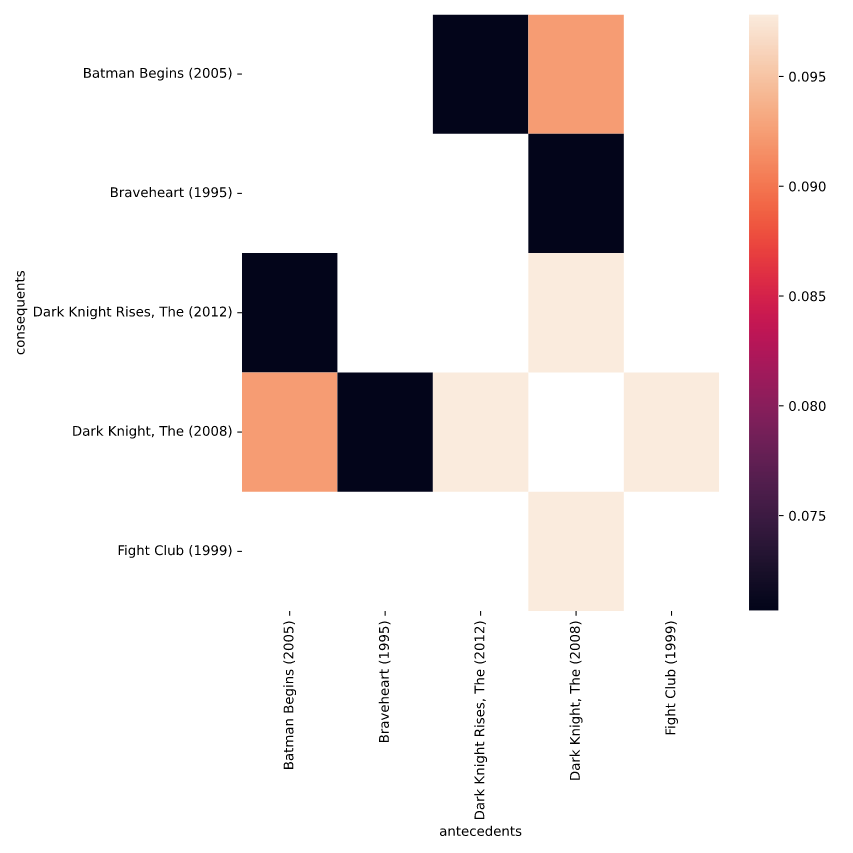

#### Heatmaps with lift

The founder likes the heatmap you've produced for her streaming service. After discussing the project further, however, you decide that that it is important to examine other metrics before making a final decision on which movies to license. In particular, the founder suggests that you select a metric that tells you whether the support values are higher than we would expect given the films' individual support values.

You recall that lift does this well and decide to use it as a metric. You also remember that lift has an important threshold at 1.0 and decide that it is important to replace the colorbar with annotations, so you can determine whether a value is greater than 1.0.

In [ ]:
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules.pivot(index = 'consequents', 
                   columns = 'antecedents', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True, cbar = False)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

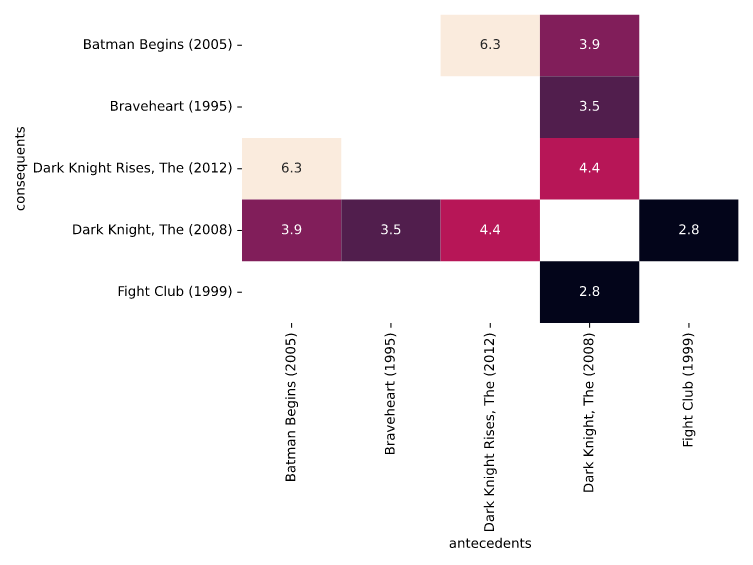

In [9]:
'''Batman Begins, The Dark Knight, and The Dark Knight Rises would make a good initial library.'''

'Batman Begins, The Dark Knight, and The Dark Knight Rises would make a good initial library.'

#### Pruning with scatterplots

After viewing your Batman-based streaming service proposal from the previous exercise, the founder realizes that her initial plan may have been too narrow. Rather than focusing on initial titles, she asks you to focus on general patterns in the association rules and then perform pruning accordingly. Your goal should be to identify a large set of strong associations.

Fortunately, you've just learned how to generate scatterplots. You decide to start by plotting support and confidence, since all optimal rules according to many common metrics are located on the confidence-support border. 

In [10]:
'''Great work! Notice that the confidence-support border roughly forms a triangle. This suggests that throwing out some low support rules would also mean that we would discard rules that are strong according to many common metrics.'''

'Great work! Notice that the confidence-support border roughly forms a triangle. This suggests that throwing out some low support rules would also mean that we would discard rules that are strong according to many common metrics.'

#### Optimality of the support-confidence border

You return to the founder with the scatterplot produced in the previous exercise and ask whether she would like you to use pruning to recover the support-confidence border. You tell her about the Bayardo-Agrawal result, but she seems skeptical and asks whether you can demonstrate this in an example.

Recalling that scatterplots can scale the size of dots according to a third metric, you decide to use that to demonstrate optimality of the support-confidence border. You will show this by scaling the dot size using the lift metric, which was one of the metrics to which Bayardo-Agrawal applies.

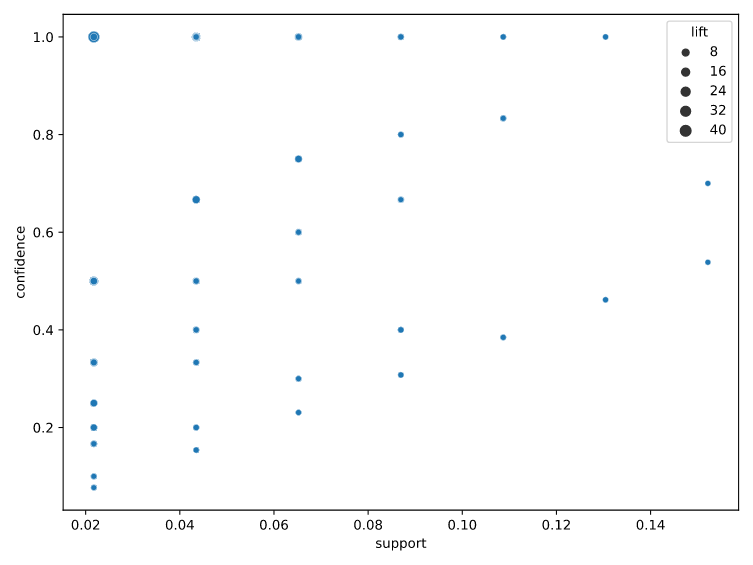

In [11]:
'''Great work! If you look at the plot carefully, you'll notice that the highest values of lift are always at the support-confidence border for any given value of supply or confidence.'''

"Great work! If you look at the plot carefully, you'll notice that the highest values of lift are always at the support-confidence border for any given value of supply or confidence."

#### Using parallel coordinates to visualize rules

Your visual demonstration in the previous exercise convinced the founder that the supply-confidence border is worthy of further exploration. She now suggests that you extract part of the border and visualize it. Since the rules that fall on the border are strong with respect to most common metrics, she argues that you should simply visualize whether a rule exists, rather than the intensity of the rule according to some metric.

In [ ]:
def parallel_coordinates(frame,class_column,cols=None, ax=None, color=None, use_columns=False, xticks=None,\ colormap=None,\n    axvlines=True,\n    axvlines_kwds=None,\ 
                         sort_labels=False,\**kwargs,):    
    """\n    Parallel coordinates plotting.\n\n    Parameters\n    ----------\n    frame : DataFrame\n    class_column : str\n        Column name containing class names.\n   
      cols : list, optional\n        A list of column names to use.\n    
      ax : matplotlib.axis, optional\n        Matplotlib axis object.\n    color : list or tuple, optional\n        
      Colors to use for the different classes.\n    use_columns : bool, optional\n        
      If true, columns will be used as xticks.\n    xticks : list or tuple, optional\n        
      A list of values to use for xticks.\n    colormap : str or matplotlib colormap, default None\n        
      Colormap to use for line colors.\n    
      axvlines : bool, optional\n        If true, vertical lines will be added at each xtick.\n   
      axvlines_kwds : keywords, optional\n        Options to be passed to axvline method for vertical lines.\n    
      sort_labels : bool, default False\n        Sort class_column labels, useful when assigning colors.\n   
      **kwargs\n        Options to pass to matplotlib plotting method.\n\n    
      Returns\n    -------\n    
      class:`matplotlib.axis.Axes`
      Examples\n    -------- 
      plot::
      :context: close-figs
      >>> df = pd.read_csv(\'https://raw.github.com/pandas-dev\'pandas/master/pandas/tests/io/data/csv/iris.csv\')
      >>> pd.plotting.parallel_coordinates(df, \'Name\', color=(\'#556270\', \'#4ECDC4\', \'#C7F464\'))
      """
     plot_backend = _get_plot_backend("matplotlib")\n    
    return plot_backend.parallel_coordinates(frame=frame, class_column=class_column, cols=cols, ax=ax, color=color, use_columns=use_columns, xticks=xticks, colormap=colormap, axvlines=axvlines, 
                                             axvlines_kwds=axvlines_kwds, sort_labels=sort_labels, **kwargs,)


In [ ]:
# Compute the frequent itemsets
frequent_itemsets = apriori(onehot, min_support = 0.05, 
                         use_colnames = True, max_len = 2)

# Compute rules from the frequent itemsets with the confidence metric
rules = association_rules(frequent_itemsets, metric = 'confidence', 
                          min_threshold = 0.50)

# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.show()

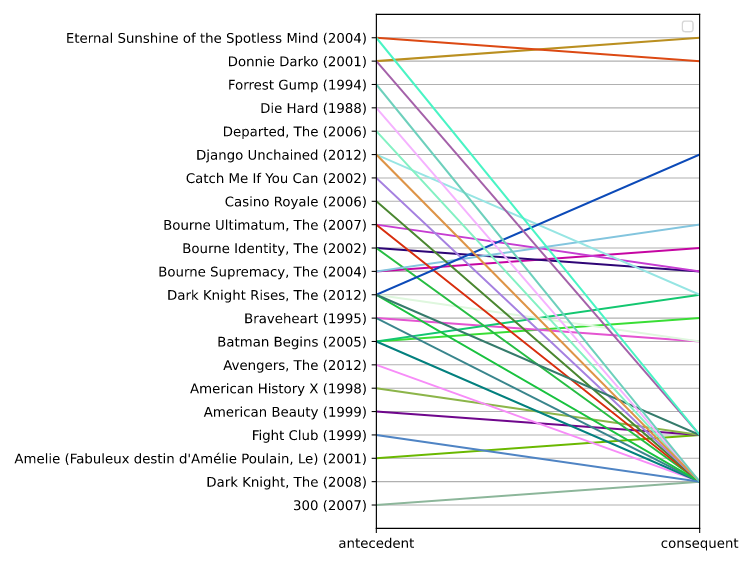

#### Refining a parallel coordinates plot

After viewing your parallel coordinates plot, the founder concludes that her decision to step away from a Batman-centered streaming platform may have been premature. Indeed, the parallel coordinates plot seems to suggest that many popular movies are strongly associated with The Dark Knight. She decides instead to pitch the idea to her staff in a meeting, but has asked you to make some refinements to the plot to make it more visually appealing for the presentation.

In [ ]:
# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule', colormap = 'ocean')
plt.legend([])
plt.show()

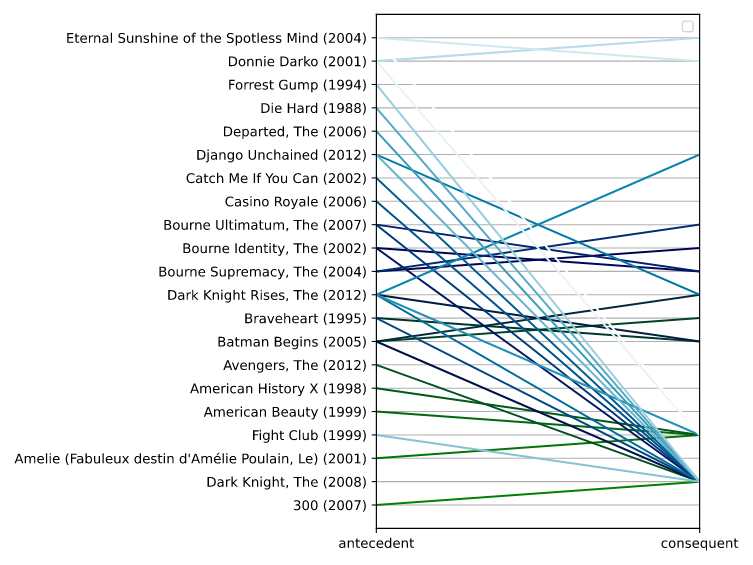